# Siamese Network based on ResNet


In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import random

from PIL import Image
from skimage import io, transform
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
from torch.autograd import Variable
import tqdm

In [2]:
def register_extension(id, extension):
    Image.EXTENSION[extension.lower()] = id.upper()
Image.register_extension = register_extension

def register_extensions(id, extensions):
    for extension in extensions:
        register_extension(id, extension)
Image.register_extensions = register_extensions

In [3]:
data_dir = '/home/tannhat_ng'
# Modify to read a pair in at a time. No longer generate a pair when coming in
# Consistency for all the run
class PainterDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.df = pd.read_csv(csv_file, usecols=['file1','file2', 'label'])
        
    def __len__(self):
        return len(self.df.index)
    
    def __getitem__(self, idx):
        os.chdir(self.img_dir)
        row = self.df.iloc[[idx]]
        filename_1 = row['file1'].item()
        filename_2 = row['file2'].item()
        label = row['label'].item()
        
        img_1 = Image.open(filename_1)
        img_2 = Image.open(filename_2)
        
        if self.transform is not None:
            img_1 = self.transform(img_1)
            img_2 = self.transform(img_2)
        
        label = torch.tensor([label]) #1 if same, 0 if not
        
        return img_1, img_2, label

In [4]:
class SiameseNetwork(nn.Module):
    def __init__(self, cnn):
        super(SiameseNetwork, self).__init__()
        self.cnn = cnn
        self.fc = nn.Sequential(
#                   nn.Linear(in_features = 16384, out_features = 4096, bias = True),
#                   nn.ReLU (inplace = True),
                  nn.Linear(in_features = 4096, out_features = 2048, bias = True),
                  nn.ReLU (inplace = True),
                  nn.Linear(in_features = 2048, out_features = 128, bias = True),
                  nn.ReLU (inplace= True),
                  nn.Linear (in_features = 128, out_features = 1, bias = True)
                                )

    def forward_once(self, x):
        output = self.cnn(x)
        output = output.view(output.size()[0], -1)
        return output

    def forward(self, img1, img2):
        output1 = self.forward_once(img1)
        output2 = self.forward_once(img2)
        features = torch.cat((output1, output2),1) # dimension: 65536
        features = self.fc(features)
        return torch.sigmoid(features)

In [5]:
class Args(object):
      def __init__(self, batch_size=64, test_batch_size=100,
            epochs=10, lr=0.01, momentum=0.5,
            log_interval=100,seed=1):
        self.batch_size = batch_size
        self.test_batch_size = test_batch_size # Input batch size for testing
        self.epochs = epochs # Number of epochs to train
        self.lr = lr # Learning rate
        self.momentum = momentum 
        self.log_interval = log_interval # Batches to wait before logging
                                         # detailed status. 0 = never
        self.seed = seed # Random seed

In [6]:
def prepare_dataset(object):
   
    train_csv = os.path.join(data_dir,'train_120k_pair.csv')    # adjust it to work on different folder
    train_dir = os.path.join(data_dir, 'train_reg')
    test_csv = os.path.join(data_dir,'test_pair.csv')
    test_dir = os.path.join(data_dir,'test_reg')
    
    kwargs = {'num_workers': 1, 'pin_memory': True}
    train_dataset = PainterDataset(csv_file = train_csv, img_dir = train_dir, transform = transforms.ToTensor())
    test_dataset = PainterDataset(csv_file = test_csv, img_dir = test_dir, transform = transforms.ToTensor())
    
    train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, **kwargs)
    test_loader = DataLoader(test_dataset, batch_size=args.test_batch_size, shuffle=True, **kwargs)
    
    return train_loader, test_loader

In [7]:
def train(model, optimizer, train_loader, epoch, total_minibatch_count, train_losses, train_accs):
  
    #training
    model.train()
    loss = nn.BCELoss()
    correct_count, total_loss, total_acc = 0., 0., 0.
    progress_bar = tqdm.tqdm(train_loader, desc='Training')
    
    for batch_idx, (input1, input2, target) in enumerate(progress_bar):
        input1, input2, target = input1.cuda(), input2.cuda(), target.cuda()
        input1, input2, target = Variable(input1), Variable(input2),Variable(target)
        
        optimizer.zero_grad()

        # Forward prediction step
        output = model(input1, input2)
        train_loss = loss(output,target.float())
        
        # Backpropagation step
        train_loss.backward()
        optimizer.step()

        pred = (output > 0.5)

        matches = (target.float() == pred.float())
        accuracy = matches.float().mean()
        correct_count += matches.sum()

        if args.log_interval != 0 and \
                total_minibatch_count % args.log_interval == 0:

            train_losses.append(train_loss.item())
            train_accs.append(accuracy.data[0])
            
        total_loss += train_loss.data
        total_acc += accuracy.data
            
        progress_bar.set_description(
            'Epoch: {} loss: {:.4f}, acc: {:.2f}'.format(
                epoch, total_loss / (batch_idx + 1), total_acc / (batch_idx + 1)))
        #progress_bar.refresh()

        total_minibatch_count += 1
    path = './resnet_trained_{}.pth'.format(epoch)
    torch.save(model.state_dict(), path)
    return total_minibatch_count

In [8]:
def test(model, test_loader, epoch, total_minibatch_count,val_losses, val_accs):
    
    # testing
    model.eval()
    loss = nn.BCELoss()
    test_loss, correct = 0., 0.
    progress_bar = tqdm.tqdm(test_loader, desc='Validation')
    with torch.no_grad():
        for input1, input2, target in progress_bar:
            
            input1, input2, target = input1.cuda(), input2.cuda(), target.cuda()
            input1, input2, target = Variable(input1), Variable(input2), Variable(target)
            
            output = model(input1, input2)
            test_loss += loss(output,target.float())
            pred =  (output > 0.5)
            correct += torch.sum(target.float() == pred.float())

    test_loss /= float(len(test_loader.dataset))
    
    acc = float(correct) / len(test_loader.dataset)

    val_losses.append(test_loss)
    val_accs.append(acc)
    
    progress_bar.clear()
    progress_bar.write(
        '\nEpoch: {} validation test results - Average val_loss: {:.4f}, val_acc: {}/{} ({:.2f}%)'.format(
            epoch, test_loss, correct, len(test_loader.dataset),
            100. * float(correct) / len(test_loader.dataset)))

    return acc

In [9]:
def run_experiment(args):

    total_minibatch_count = 0
    torch.cuda.manual_seed(args.seed)
    
    train_loader, test_loader, = prepare_dataset(args)
    epochs_to_run = args.epochs
#     cnn = models.resnet152(pretrained=True)
    cnn = models.resnet18(pretrained=True)
    modules = list(cnn.children())[:-1]      # delete the last fc layer.
    cnn = nn.Sequential(*modules)
    for param in cnn.parameters():
        param.requires_grad = False
    model = SiameseNetwork(cnn).cuda()
    optimizer = optim.SGD(model.parameters(), lr = args.lr, momentum = args.momentum)
    val_acc = 0
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    for epoch in range(1, epochs_to_run + 1):
        
        total_minibatch_count = train(model, optimizer, train_loader, epoch, total_minibatch_count, train_losses, train_accs)
        val_acc = test(model, test_loader, epoch, total_minibatch_count, val_losses, val_accs)
    
    fig, axes = plt.subplots(1,4, figsize=(13,4))
    # plot the losses and acc
    plt.title("ResNet")
    axes[0].plot(train_losses)
    axes[0].set_title("Loss")
    axes[1].plot(train_accs)
    axes[1].set_title("Acc")
    axes[2].plot(val_losses)
    axes[2].set_title("Val loss")
    axes[3].plot(val_accs)
    axes[3].set_title("Val Acc")
    
    return model

Training:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch: 1 validation test results - Average val_loss: 0.0058, val_acc: 2103/3000 (70.10%)


Training:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch: 2 validation test results - Average val_loss: 0.0054, val_acc: 2155/3000 (71.83%)


Training:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch: 3 validation test results - Average val_loss: 0.0054, val_acc: 2184/3000 (72.80%)


Training:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch: 4 validation test results - Average val_loss: 0.0051, val_acc: 2244/3000 (74.80%)


Training:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch: 5 validation test results - Average val_loss: 0.0052, val_acc: 2227/3000 (74.23%)


Training:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch: 6 validation test results - Average val_loss: 0.0054, val_acc: 2225/3000 (74.17%)


Training:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch: 7 validation test results - Average val_loss: 0.0055, val_acc: 2192/3000 (73.07%)


Training:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch: 8 validation test results - Average val_loss: 0.0054, val_acc: 2213/3000 (73.77%)


Training:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch: 9 validation test results - Average val_loss: 0.0054, val_acc: 2232/3000 (74.40%)


Validation: 100%|██████████| 30/30 [00:30<00:00,  1.01it/s]



Epoch: 10 validation test results - Average val_loss: 0.0055, val_acc: 2238/3000 (74.60%)


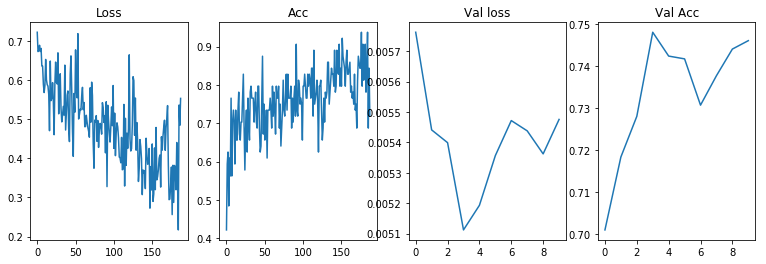

In [10]:
args = Args()
model = run_experiment(args)